# 새로운 시작

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/open/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/open


## 데이터 로딩 및 전처리

### Subtask:
이전 셀의 코드를 사용하여 데이터를 로드하고 전처리합니다. 범주형/수치형 컬럼을 사용자 요구사항에 맞게 재정의하고, 각 컬럼 타입에 맞는 스케일링 및 인코딩을 적용합니다. `seq` 컬럼은 문자열 그대로 유지합니다.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import os

train_df = pd.read_parquet("./train-001.parquet", engine="pyarrow")
test = pd.read_parquet("./test.parquet", engine="pyarrow").drop(columns=['ID'])

In [ ]:
target_col = "clicked"
seq_col = "seq"

# 범주형 컬럼
categorical_cols = ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour', 'l_feat_14']

# 수치형 컬럼
numerical_feat_cols = [c for c in train_df.columns if c.startswith('feat_')]
numerical_history_cols = [c for c in train_df.columns if c.startswith('history_')]
numerical_l_feat_cols = [c for c in train_df.columns if c.startswith('l_feat_') and c not in categorical_cols]
numerical_cols = numerical_feat_cols + numerical_history_cols + numerical_l_feat_cols

# Label Encoding for categorical features
vocab_sizes = {}
for col in categorical_cols:
    all_categories = pd.concat([train_df[col], test[col]]).astype(str).unique()
    vocab_sizes[col] = len(all_categories) + 1
    le = LabelEncoder()
    le.fit(all_categories)
    train_df[col] = le.transform(train_df[col].astype(str)).astype(int)
    test[col] = le.transform(test[col].astype(str)).astype(int)

# StandardScaler for numerical features
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols]).astype(float)
test[numerical_cols] = scaler.transform(test[numerical_cols]).astype(float)

# 결측값 / 무한대 처리
train_df[numerical_cols] = train_df[numerical_cols].fillna(0).replace([np.inf, -np.inf], 0)
test[numerical_cols] = test[numerical_cols].fillna(0).replace([np.inf, -np.inf], 0)

## Dataset 및 DataLoader 수정

### Subtask:
새로운 모델 구조에 맞게 `ClickDataset` 클래스를 수정하거나 새로 정의합니다. 특히 `seq` 데이터를 시퀀스 형태로 처리하고, 다른 피처들을 분리하여 반환하도록 합니다. Collate 함수도 수정하여 `seq` 데이터 패딩 및 길이를 처리합니다.

In [ ]:
class ClickDataset(Dataset):
    def __init__(self, df, categorical_cols, numerical_cols, seq_col, target_col=None, has_target=True):
        self.df = df.reset_index(drop=True)
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols
        self.seq_col = seq_col
        self.target_col = target_col
        self.has_target = has_target
        if self.has_target:
            self.y = self.df[self.target_col].astype(np.float32).values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cat_features = torch.tensor(self.df.loc[idx, self.categorical_cols].values.astype(int), dtype=torch.long)
        num_features = torch.tensor(self.df.loc[idx, self.numerical_cols].values.astype(float), dtype=torch.float)

        seq_string = self.df.loc[idx, self.seq_col]
        if isinstance(seq_string, str) and seq_string:
            try:
                seq_array = np.fromstring(seq_string, sep=",", dtype=np.float32)
            except ValueError:
                seq_array = np.array([0.0], dtype=np.float32)
        else:
            seq_array = np.array([0.0], dtype=np.float32)

        seq_tensor = torch.from_numpy(seq_array)
        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float)
            return cat_features, num_features, seq_tensor, y
        else:
            return cat_features, num_features, seq_tensor

def collate_fn_train(batch):
    cat_features, num_features, seqs, ys = zip(*batch)
    cat_features = torch.stack(cat_features)
    num_features = torch.stack(num_features)
    ys = torch.stack(ys).unsqueeze(1)
    seqs_padded = rnn_utils.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long).clamp(min=1)
    return cat_features, num_features, seqs_padded, seq_lengths, ys

def collate_fn_infer(batch):
    cat_features, num_features, seqs = zip(*batch)
    cat_features = torch.stack(cat_features)
    num_features = torch.stack(num_features)
    seqs_padded = rnn_utils.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long).clamp(min=1)
    return cat_features, num_features, seqs_padded, seq_lengths

## 모델 구조 정의

### Subtask:
사용자 요구사항에 맞춰 새로운 `ComplexModel` 클래스를 정의합니다. 이 클래스 안에는 다음 서브 모듈이 포함됩니다.
- 범주형 피처를 위한 임베딩 레이어와 Transformer Encoder.
- 시퀀스 데이터 처리를 위한 LSTM.
- `feat_*_*` 수치형 피처를 위한 MLP.
- `history_*_*` 수치형 피처를 위한 MLP.
- 모든 서브 모듈의 출력을 결합하고 최종 예측을 수행하는 MLP.

In [ ]:
class TransformerTabularModel(nn.Module):
    def __init__(self, vocab_sizes, embedding_dims, numerical_dim, lstm_hidden_dim=64,
                 transformer_heads=4, transformer_layers=2, dropout=0.1):
        super().__init__()

        # Cat embedding
        self.embedding_layers = nn.ModuleDict({col: nn.Embedding(vocab_sizes[col], embedding_dims[col])
                                               for col in vocab_sizes.keys()})
        total_cat_emb_dim = sum(embedding_dims.values())
        self.cat_proj = nn.Linear(total_cat_emb_dim, 64)

        # Num MLP
        self.num_mlp = nn.Sequential(
            nn.Linear(numerical_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

        # Seq LSTM
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_dim, batch_first=True, num_layers=1)
        self.seq_proj = nn.Linear(lstm_hidden_dim, 64)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=transformer_heads, batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(64*3, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, cat_x, num_x, seq_x, seq_lengths, apply_agata=False):
        cat_emb = [self.embedding_layers[col](cat_x[:, i]) for i, col in enumerate(self.embedding_layers.keys())]
        cat_emb = torch.cat(cat_emb, dim=1)
        cat_token = self.cat_proj(cat_emb).unsqueeze(1)

        num_token = self.num_mlp(num_x).unsqueeze(1)

        seq_x = seq_x.unsqueeze(-1)
        packed_seq = rnn_utils.pack_padded_sequence(seq_x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed_seq)
        seq_token = self.seq_proj(h_n[-1]).unsqueeze(1)

        tokens = torch.cat([cat_token, num_token, seq_token], dim=1)

        # --- ★ AGATa: Transformer 전에 feature mask/perturb ---
        if apply_agata and self.training:
            # 예시: attention weight가 낮은 토큰을 랜덤으로 dropout
            mask = (torch.rand_like(tokens) > 0.1).float()  # 10% dropout
            tokens = tokens * mask

        transformed = self.transformer(tokens)
        pooled = transformed.flatten(start_dim=1)

        logits = self.final_mlp(pooled).squeeze(1)
        return logits


def calculate_weighted_logloss(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1-eps)
    mask_0 = (y_true==0)
    mask_1 = (y_true==1)
    ll_0 = -np.mean(np.log(1-y_pred[mask_0])) if mask_0.sum()>0 else 0
    ll_1 = -np.mean(np.log(y_pred[mask_1])) if mask_1.sum()>0 else 0
    return 0.5*ll_0 + 0.5*ll_1

def calculate_competition_score(y_true, y_pred):
    ap = average_precision_score(y_true, y_pred)
    wll = calculate_weighted_logloss(y_true, y_pred)
    score = 0.5*ap + 0.5*(1/(1+wll))
    return score, ap, wll

In [ ]:
def train_model(train_df, categorical_cols, numerical_cols, seq_col, target_col, vocab_sizes, embedding_dims,
                batch_size=512, epochs=10, lr=1e-3, device="cuda"):

    tr_df, va_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)
    train_dataset = ClickDataset(tr_df, categorical_cols, numerical_cols, seq_col, target_col)
    val_dataset = ClickDataset(va_df, categorical_cols, numerical_cols, seq_col, target_col)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_train, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_train, num_workers=2)

    model = TransformerTabularModel(vocab_sizes=vocab_sizes, embedding_dims=embedding_dims, numerical_dim=len(numerical_cols)).to(device)
    pos_count = tr_df[target_col].sum()
    neg_count = len(tr_df) - pos_count
    pos_weight = torch.tensor(neg_count/pos_count, dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    best_val_score = -float('inf')
    best_model_state_dict = None
    history = {'train_losses':[], 'val_losses':[], 'train_comp_scores':[], 'val_comp_scores':[]}

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0
        train_preds, train_true = [], []
        for cat_x, num_x, seq_x, seq_len, ys in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            cat_x, num_x, seq_x, seq_len, ys = cat_x.to(device), num_x.to(device), seq_x.to(device), seq_len.to(device), ys.to(device)
            optimizer.zero_grad()
            logits = model(cat_x, num_x, seq_x, seq_len, apply_agata=True)
            loss = criterion(logits, ys.squeeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * ys.size(0)
            train_preds.append(torch.sigmoid(logits).detach().cpu().numpy())
            train_true.append(ys.squeeze(1).cpu().numpy())

        train_loss /= len(train_dataset)
        train_preds = np.concatenate(train_preds)
        train_true = np.concatenate(train_true)
        train_score, _, _ = calculate_competition_score(train_true, train_preds)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_true = [], []
        with torch.no_grad():
            for cat_x, num_x, seq_x, seq_len, ys in val_loader:
                cat_x, num_x, seq_x, seq_len, ys = cat_x.to(device), num_x.to(device), seq_x.to(device), seq_len.to(device), ys.to(device)
                logits = model(cat_x, num_x, seq_x, seq_len, apply_agata=False)
                loss = criterion(logits, ys.squeeze(1))
                val_loss += loss.item() * len(ys)
                val_preds.append(torch.sigmoid(logits).cpu().numpy())
                val_true.append(ys.squeeze(1).cpu().numpy())

        val_loss /= len(val_dataset)
        val_preds = np.concatenate(val_preds)
        val_true = np.concatenate(val_true)
        val_score, _, _ = calculate_competition_score(val_true, val_preds)

        scheduler.step()
        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)
        history['train_comp_scores'].append(train_score)
        history['val_comp_scores'].append(val_score)

        if val_score > best_val_score:
            best_val_score = val_score
            best_model_state_dict = model.state_dict()
            torch.save(best_model_state_dict, './low_AGATa_best_model.pth')

        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Score: {train_score:.4f} | Val Loss: {val_loss:.4f} | Val Score: {val_score:.4f}")

    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict)

    return model, history

## 모델 학습, 추론 및 제출 파일 생성 (컬럼 목록 정의 포함)

### Subtask:
정의된 `ComplexModel`을 사용하여 모델을 학습하고, 학습된 모델로 테스트 데이터에 대한 추론을 수행하여 제출 파일을 생성합니다. 필요한 컬럼 목록 변수들을 이 셀 내에서 명확히 정의합니다.

In [ ]:
embedding_dims = {'gender':4, 'age_group':4, 'inventory_id':4, 'day_of_week':4, 'hour':4, 'l_feat_14':16}
device = "cuda" if torch.cuda.is_available() else "cpu"

CFG = {'BATCH_SIZE':1024, 'EPOCHS':15, 'LEARNING_RATE':1e-3}

model, history = train_model(train_df, categorical_cols, numerical_cols, seq_col, target_col,
                             vocab_sizes, embedding_dims,
                             batch_size=CFG['BATCH_SIZE'], epochs=CFG['EPOCHS'], lr=CFG['LEARNING_RATE'], device=device)

Train Epoch 1: 100%|██████████| 8363/8363 [21:05<00:00,  6.61it/s]


[Epoch 1] Train Loss: 1.2181 | Train Score: 0.3361 | Val Loss: 1.2029 | Val Score: 0.3428


Train Epoch 2: 100%|██████████| 8363/8363 [21:14<00:00,  6.56it/s]


[Epoch 2] Train Loss: 1.1964 | Train Score: 0.3418 | Val Loss: 1.1969 | Val Score: 0.3461


Train Epoch 3: 100%|██████████| 8363/8363 [21:24<00:00,  6.51it/s]


[Epoch 3] Train Loss: 1.1902 | Train Score: 0.3433 | Val Loss: 1.1904 | Val Score: 0.3467


Train Epoch 4: 100%|██████████| 8363/8363 [21:16<00:00,  6.55it/s]


[Epoch 4] Train Loss: 1.1853 | Train Score: 0.3449 | Val Loss: 1.1886 | Val Score: 0.3484


Train Epoch 5: 100%|██████████| 8363/8363 [21:21<00:00,  6.53it/s]


[Epoch 5] Train Loss: 1.1820 | Train Score: 0.3461 | Val Loss: 1.1871 | Val Score: 0.3484


Train Epoch 6: 100%|██████████| 8363/8363 [21:19<00:00,  6.54it/s]


[Epoch 6] Train Loss: 1.1793 | Train Score: 0.3470 | Val Loss: 1.1866 | Val Score: 0.3485


Train Epoch 7: 100%|██████████| 8363/8363 [21:16<00:00,  6.55it/s]


[Epoch 7] Train Loss: 1.1764 | Train Score: 0.3480 | Val Loss: 1.1843 | Val Score: 0.3497


Train Epoch 8: 100%|██████████| 8363/8363 [21:21<00:00,  6.52it/s]


[Epoch 8] Train Loss: 1.1724 | Train Score: 0.3492 | Val Loss: 1.1847 | Val Score: 0.3500


Train Epoch 9: 100%|██████████| 8363/8363 [21:25<00:00,  6.51it/s]


[Epoch 9] Train Loss: 1.1691 | Train Score: 0.3502 | Val Loss: 1.1859 | Val Score: 0.3499


Train Epoch 10: 100%|██████████| 8363/8363 [21:23<00:00,  6.52it/s]


[Epoch 10] Train Loss: 1.1654 | Train Score: 0.3512 | Val Loss: 1.1830 | Val Score: 0.3511


Train Epoch 11: 100%|██████████| 8363/8363 [21:16<00:00,  6.55it/s]


[Epoch 11] Train Loss: 1.1623 | Train Score: 0.3521 | Val Loss: 1.1882 | Val Score: 0.3507


Train Epoch 12: 100%|██████████| 8363/8363 [21:20<00:00,  6.53it/s]


[Epoch 12] Train Loss: 1.1593 | Train Score: 0.3530 | Val Loss: 1.1845 | Val Score: 0.3513


Train Epoch 13: 100%|██████████| 8363/8363 [21:22<00:00,  6.52it/s]


[Epoch 13] Train Loss: 1.1560 | Train Score: 0.3540 | Val Loss: 1.1881 | Val Score: 0.3513


Train Epoch 14: 100%|██████████| 8363/8363 [21:18<00:00,  6.54it/s]


[Epoch 14] Train Loss: 1.1538 | Train Score: 0.3545 | Val Loss: 1.1870 | Val Score: 0.3514


Train Epoch 15: 100%|██████████| 8363/8363 [21:20<00:00,  6.53it/s]


[Epoch 15] Train Loss: 1.1522 | Train Score: 0.3550 | Val Loss: 1.1894 | Val Score: 0.3512


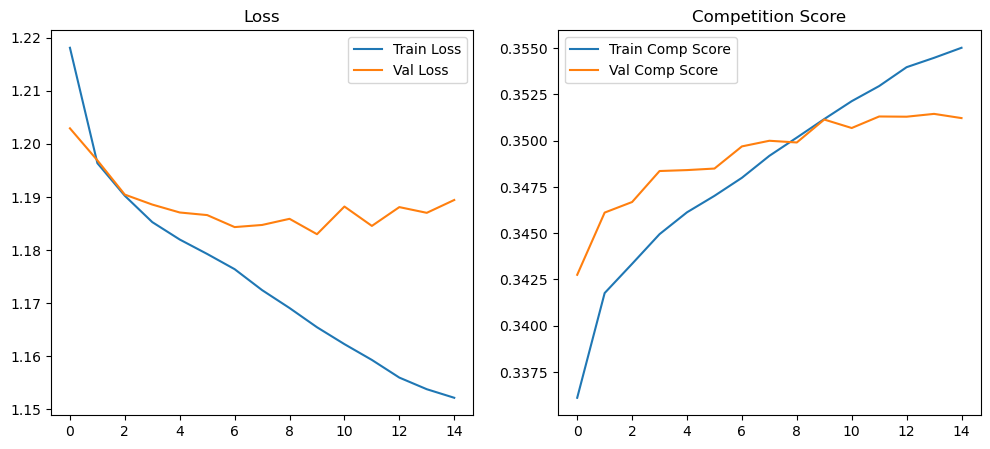

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history['train_comp_scores'], label='Train Comp Score')
plt.plot(history['val_comp_scores'], label='Val Comp Score')
plt.legend(); plt.title("Competition Score")
plt.show()

In [ ]:
test_dataset = ClickDataset(test, categorical_cols, numerical_cols, seq_col, has_target=False)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, collate_fn=collate_fn_infer, num_workers=2)

model.eval()
outs = []
with torch.no_grad():
    for cat_x, num_x, seq_x, seq_len in tqdm(test_loader, desc="Inference"):
        cat_x, num_x, seq_x, seq_len = cat_x.to(device), num_x.to(device), seq_x.to(device), seq_len.to(device)
        logits = model(cat_x, num_x, seq_x, seq_len, apply_agata=False)
        outs.append(torch.sigmoid(logits).cpu())

test_preds = torch.cat(outs).numpy()

Inference: 100%|██████████| 1492/1492 [03:34<00:00,  6.94it/s]


In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['clicked'] = test_preds
submit.to_csv('./low_AGATa_submission.csv', index=False)
print("✅ Submission file created: TransformerTabular_submission.csv")

✅ Submission file created: TransformerTabular_submission.csv
